# Deep Forest Project - CNN Models to Forest Image Classification

### PROMWANG Nattirat, BATINA-AGASA Fervent, SOW Assane 

In [ ]:
#    The main objective of this project is to
#    analyse satellite images of Amazon rainforest to classify (2 classes) as 'deforestation' or 'pollution'

#    We use pre-trained model ResNet50, VGG, and MobileNetV2 and also build our own model called DeepForestNet
#    At the end of this notebook, we made performance comparison between these 4 models by considering validation loss 
#    and accuracy. 

# 0. Explore Data

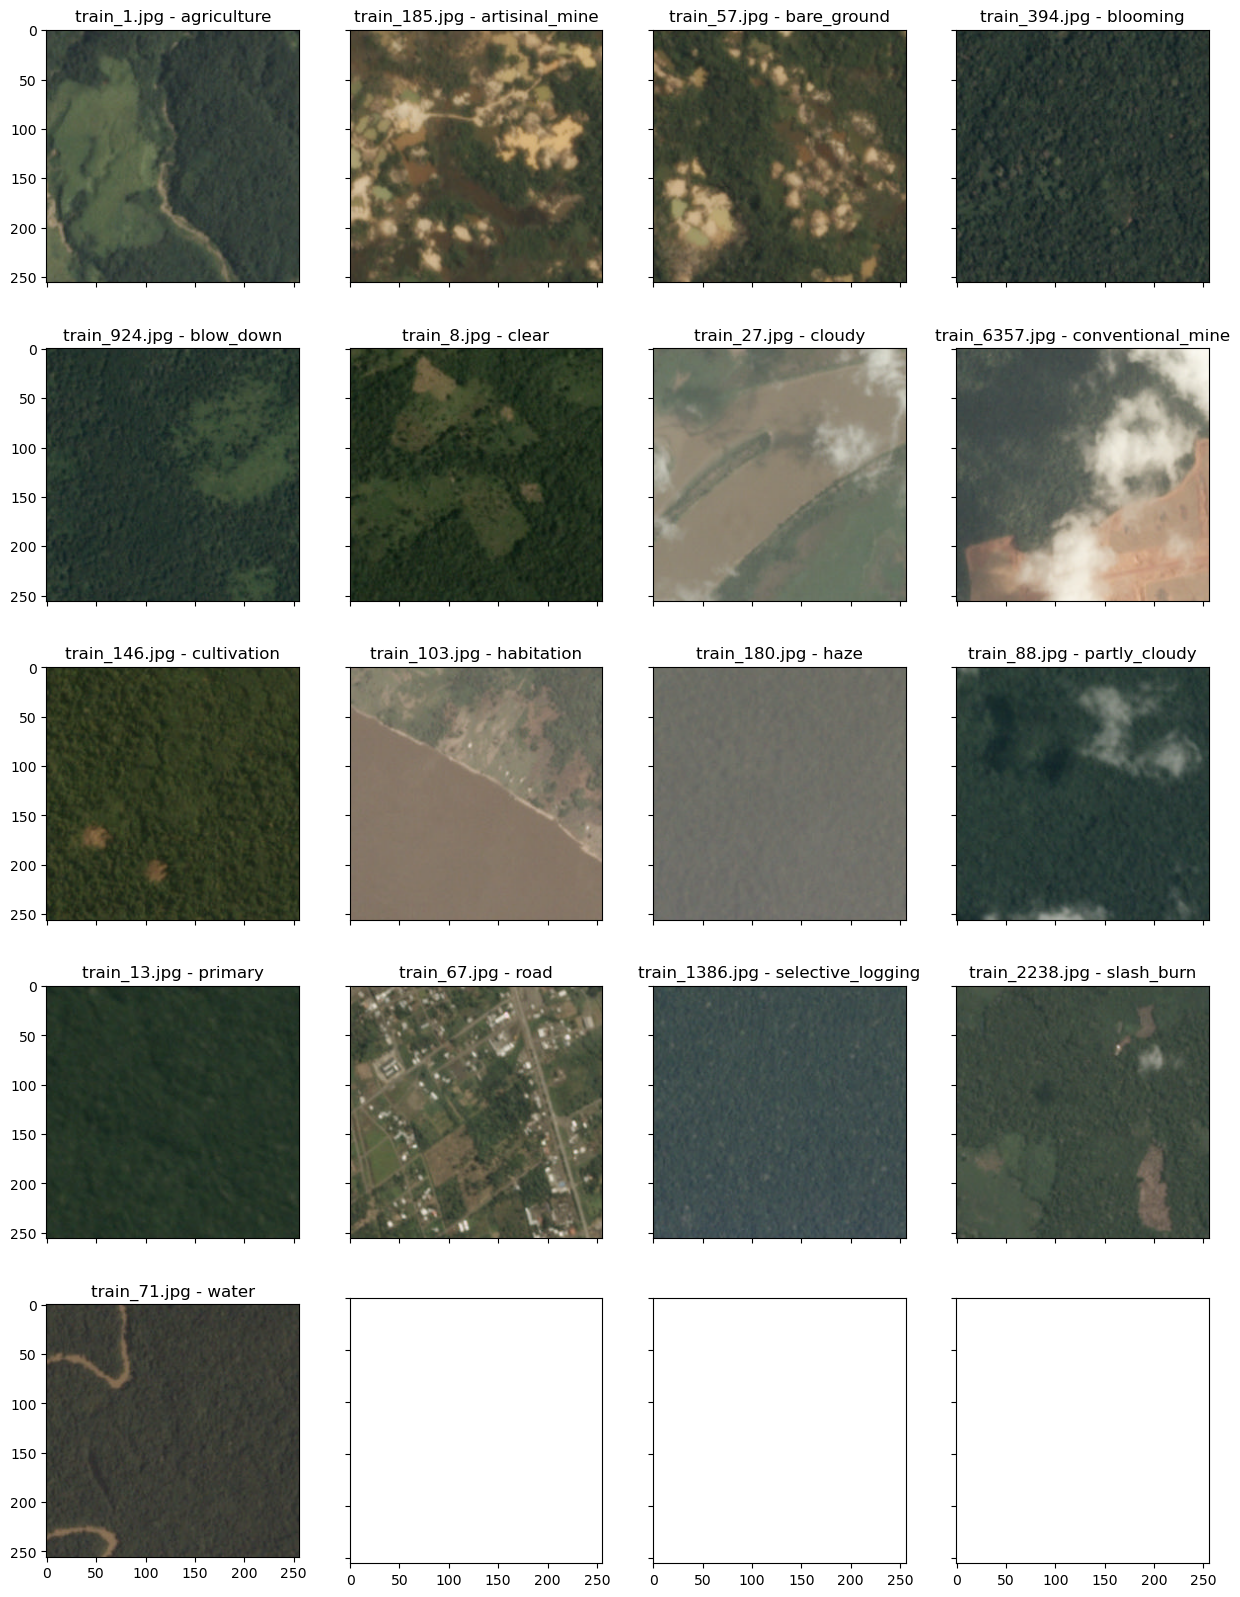

In [20]:
# Our data consists of satellite images of the Amazon Rainforest as well as its label embeded data (tags)

# Import dataset

import os
import matplotlib.pyplot as plt

# Images for training 
train_image_directory = r'C:/Users/natti/OneDrive/Desktop/DS/ML/Project Deep Forest/Dataset/train-jpg/train-jpg'

# Tags file path
csv_file_path = r'C:/Users/natti/OneDrive/Desktop/DS/ML/Project Deep Forest/Dataset/train_v2.csv/train_v2.csv'

images_title = [df[df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' for i, label in enumerate(labels)]

_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels)):
    img_path = os.path.join(train_image_directory, image_name)  
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(f'{image_name} - {label}')


In [21]:
# We would like to check the distribution of the tags on our dataset

# Therefore, we use One-hot encode the labels

dummies = df['tags'].str.get_dummies(' ')
df = pd.concat([df, dummies], axis=1)

labels = dummies.columns.values
N_LABELS = len(labels)
dummies

agriculture  artisinal_mine  bare_ground  blooming  blow_down  clear  \
0                0               0            0         0          0      0   
1                1               0            0         0          0      1   
2                0               0            0         0          0      1   
3                0               0            0         0          0      1   
4                1               0            0         0          0      1   
...            ...             ...          ...       ...        ...    ...   
40474            0               0            0         0          0      1   
40475            0               0            0         0          0      0   
40476            1               0            0         0          0      1   
40477            1               0            0         0          0      1   
40478            1               0            0         0          0      0   

       cloudy  conventional_mine  cultivation  habitation  haze  \
0           0                  0            0           0     1   
1           0                  0            0           0     0   
2           0                  0            0           0     0   
3           0                  0            0           0     0   
4           0                  0            0           1     0   
...       ...                ...          ...         ...   ...   
40474       0                  0            0           0     0   
40475       1                  0            0           0     0   
40476       0                  0            0           0     0   
40477       0                  0            0           0     0   
40478       0                  0            1           0     0   

       partly_cloudy  primary  road  selective_logging  slash_burn  water  
0                  0        1     0                  0           0      0  
1                  0        1     0                  0           0      1  
2                  0        1     0                  0           0      0  
3                  0        1     0                  0           0      0  
4                  0        1     1                  0           0      0  
...              ...      ...   ...                ...         ...    ...  
40474              0        1     0                  0           0      0  
40475              0        0     0                  0           0      0  
40476              0        1     0                  0           0      0  
40477              0        1     1                  0           0      0  
40478              1        1     0                  0           0      0  

[40479 rows x 17 columns]

In [9]:
# Countplot of label distribution

label_count = dummies.sum(axis=0).sort_values()
print(label_count)

blow_down               98
conventional_mine      100
slash_burn             209
blooming               332
artisinal_mine         339
selective_logging      340
bare_ground            862
cloudy                2089
haze                  2697
habitation            3660
cultivation           4477
partly_cloudy         7261
water                 7411
road                  8071
agriculture          12315
clear                28431
primary              37513
dtype: int64


In [25]:
# According to NASA Earth Observatory, One of the main cause of deforestation is the expansion of infrastructure and urbanization
# Thus, we classified the tag 'habitation' as a sign of 'deforestation' 

# Another issues is in the context of farmers and ranchers who slash and burn the remaining forest. 
# Therefore, we also classified 'slash_burn' to 'pollution'

# 1. Data Preprocessing

## 1.1 Check if images are all the same dimensions

In [2]:
from PIL import Image
import os

def check_image_sizes(directory):
    image_sizes = set()  

    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            filepath = os.path.join(directory, filename)
            with Image.open(filepath) as img:
                size = img.size
                image_sizes.add(size)

    return image_sizes

In [30]:
# Specify the directories of training images 
train_image_directory = r'C:/Users/natti/OneDrive/Desktop/DS/ML/Project Deep Forest/Dataset/train-jpg/train-jpg'

# Check image sizes for training images
train_sizes = check_image_sizes(train_image_directory)
if len(train_sizes) == 1:
    print("All training images have the same size:", train_sizes.pop())
else:
    print("Training images have different sizes:", train_sizes)

All training images have the same size: (256, 256)


In [31]:
# Specify the directories of testing images 
test_image_directory = r'C:/Users/natti/OneDrive/Desktop/DS/ML/Project Deep Forest/Dataset/test-jpg/test-jpg'

# Check image sizes for test images
test_sizes = check_image_sizes(test_image_directory)
if len(test_sizes) == 1:
    print("All test images have the same size:", test_sizes.pop())
else:
    print("Test images have different sizes:", test_sizes)

All test images have the same size: (256, 256)


## 1.2 Check missing values

In [3]:
# Check if there is any value in our csv file that contains label embeded data (tags)

import pandas as pd

# Specify the path to CSV file
csv_file_path = r'C:/Users/natti/OneDrive/Desktop/DS/ML/Project Deep Forest/Dataset/train_v2.csv/train_v2.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Check for missing values
missing_values = df.isnull().sum()

# Print the result
if missing_values.sum() == 0:
    print("No missing values in the CSV file.")
else:
    print("Missing values found:")
    print(missing_values)

No missing values in the CSV file.


# 2. Pre-trained Models

## 2.0 Import libraries and load necessary data 

In [14]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout

In [15]:
# Load labels
labels_df = pd.read_csv(r'C:/Users/natti/OneDrive/Desktop/DS/ML/Project Deep Forest/Dataset/train_v2.csv/train_v2.csv')


labels_df['deforestation'] = labels_df['tags'].apply(lambda x: 1 if 'habitation' in x else 0)
labels_df['pollution'] = labels_df['tags'].apply(lambda x: 1 if 'slash_burn' in x else 0)

In [16]:
# Split dataset into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# Add file extensions to image filenames
train_df['image_name'] = train_df['image_name'].apply(lambda x: f"{x}.jpg")
val_df['image_name'] = val_df['image_name'].apply(lambda x: f"{x}.jpg")

In [17]:
# Set the path to dataset directory
data_dir = r'C:/Users/natti/OneDrive/Desktop/DS/ML/Project Deep Forest/Dataset/train-jpg/train-jpg'

In [18]:
# Create dataset generators for training and validation sets
def create_dataset_generator(df, data_dir, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        df, directory=data_dir, x_col='image_name', y_col=['deforestation', 'pollution'],
        target_size=target_size, batch_size=batch_size, class_mode='raw')
    return generator

In [19]:
# %%

train_generator = create_dataset_generator(train_df, data_dir)
val_generator = create_dataset_generator(val_df, data_dir)

Found 32383 validated image filenames.
Found 8096 validated image filenames.


## 2.1 Pre-trained ResNet50

In [10]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add dropout layers to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base_model layers
for layer in base_model.layers:
    layer.trainable = False


# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

In [11]:
# Train ResNet model
history = model.fit(train_generator, epochs=3, validation_data=val_generator)

from tensorflow.keras.preprocessing import image

def predict_deforestation_pollution(model, img_path, img_size=(224, 224)):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Make a prediction using model
    preds = model.predict(x)

    return preds

Epoch 1/3
1012/1012 [==============================] - 2714s 3s/step - loss: 0.1711 - auc: 0.7580 - val_loss: 0.1599 - val_auc: 0.8824
Epoch 2/3
1012/1012 [==============================] - 2542s 3s/step - loss: 0.1564 - auc: 0.8167 - val_loss: 0.1533 - val_auc: 0.8821
Epoch 3/3
1012/1012 [==============================] - 2505s 2s/step - loss: 0.1528 - auc: 0.8305 - val_loss: 0.1642 - val_auc: 0.8789


1/1 [==============================] - 3s 3s/step


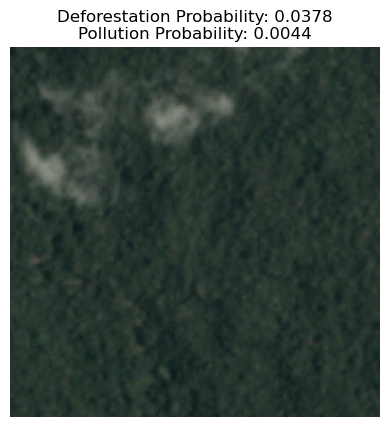

1/1 [==============================] - 0s 221ms/step


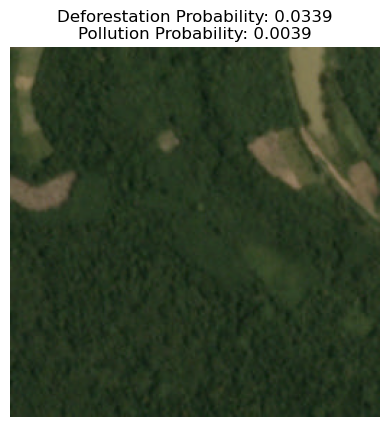

1/1 [==============================] - 0s 191ms/step


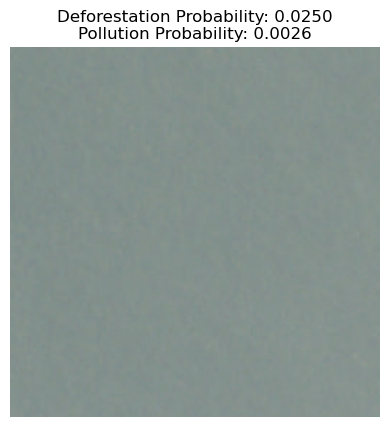

1/1 [==============================] - 0s 196ms/step


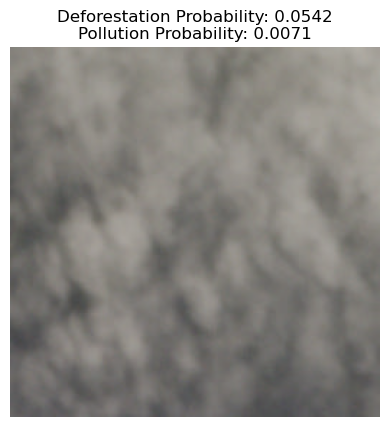

1/1 [==============================] - 0s 199ms/step


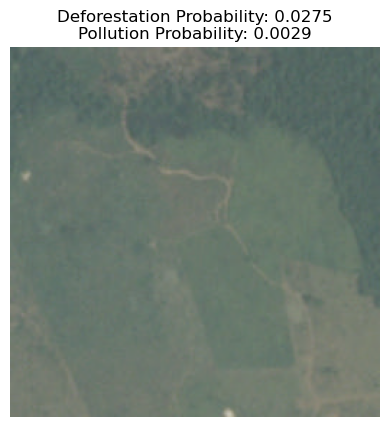

In [12]:
# Function to display predictions with ResNet model
def display_image_with_predictions(img_path, deforestation_prob, pollution_prob):
    img = image.load_img(img_path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Deforestation Probability: {deforestation_prob:.4f}\nPollution Probability: {pollution_prob:.4f}")
    plt.axis("off")
    plt.show()

# Set path to the test dataset directory
test_data_dir = r'C:\Users\natti\OneDrive\Desktop\DS\ML\Project Deep Forest\Dataset\test-jpg\test-jpg'

# Choose a few random images from test dataset
test_images = random.sample(os.listdir(test_data_dir), 5)

# Evaluate model's performance on selected test images
for img_name in test_images:
    img_path = os.path.join(test_data_dir, img_name)
    preds = predict_deforestation_pollution(model, img_path)

    deforestation_prob = preds[0][0]
    pollution_prob = preds[0][1]

    display_image_with_predictions(img_path, deforestation_prob, pollution_prob)


#Calculate loss function 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

## 2.2 Pre-trained VGG

In [10]:
# Everything above remains the same as the other model
# Now everything below is specific to the VGG model

from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model
base_model_vgg = VGG16(weights='imagenet', include_top=False)

# Add layers to the model
x_vgg = base_model_vgg.output
x_vgg = GlobalAveragePooling2D()(x_vgg)
x_vgg = Dense(2048, activation='relu')(x_vgg)
x_vgg = Dense(1024, activation='relu')(x_vgg)
predictions_vgg = Dense(2, activation='sigmoid')(x_vgg)

# Create final model
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)

58889256/58889256 [==============================] - 4s 0us/step


In [11]:
# Freeze the base_model_vgg layers
for layer in base_model_vgg.layers:
    layer.trainable = False

In [12]:
# Compile model
model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

In [13]:
# Train the model
history_vgg = model_vgg.fit(train_generator, epochs=3, validation_data=val_generator)

Epoch 1/3
1012/1012 [==============================] - 7567s 7s/step - loss: 0.1133 - auc: 0.9155 - val_loss: 0.1020 - val_auc: 0.9309
Epoch 2/3
1012/1012 [==============================] - 8750s 9s/step - loss: 0.1028 - auc: 0.9308 - val_loss: 0.1035 - val_auc: 0.9407
Epoch 3/3
1012/1012 [==============================] - 12226s 12s/step - loss: 0.1019 - auc: 0.9327 - val_loss: 0.1009 - val_auc: 0.9335


In [17]:
# Function to predict with VGG16 model
def predict_deforestation_pollution_vgg(model, img_path, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    preds = model.predict(x)
    return preds

In [18]:
# Function to display predictions with VGG16 model
def display_image_with_predictions_vgg(img_path, deforestation_prob, pollution_prob):
    img = image.load_img(img_path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Deforestation Probability: {deforestation_prob:.4f}\nPollution Probability: {pollution_prob:.4f}")
    plt.axis("off")
    plt.show()

In [23]:
# Set path to the test dataset directory
test_data_dir = r'C:\Users\natti\OneDrive\Desktop\DS\ML\Project Deep Forest\Dataset\test-jpg\test-jpg'

In [24]:
# Choose a few random images from test dataset
test_images_vgg = random.sample(os.listdir(test_data_dir), 5)

1/1 [==============================] - 1s 503ms/step


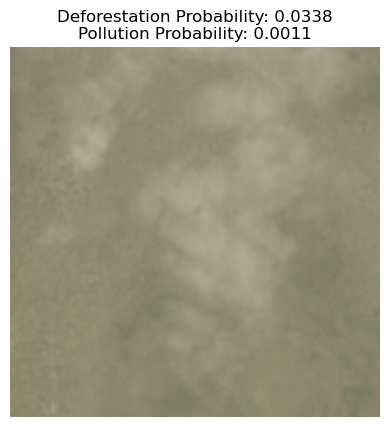

1/1 [==============================] - 0s 185ms/step


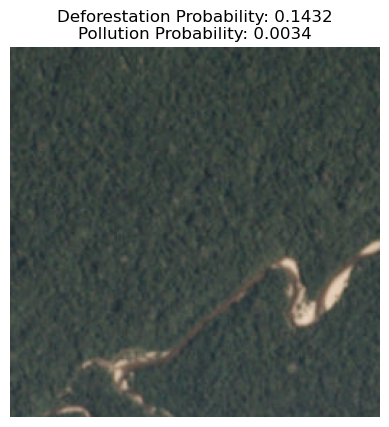

1/1 [==============================] - 0s 162ms/step


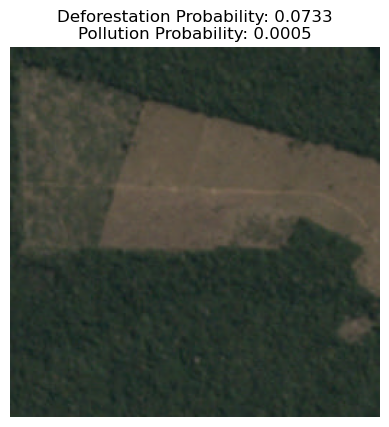

1/1 [==============================] - 0s 190ms/step


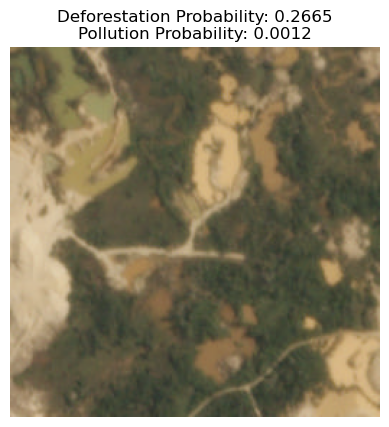

1/1 [==============================] - 0s 169ms/step


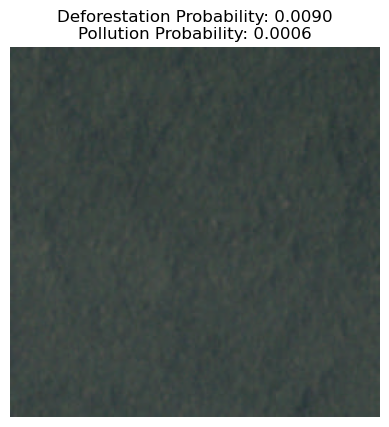

In [25]:
# Evaluate model's performance on selected test images
for img_name in test_images_vgg:
    img_path = os.path.join(test_data_dir, img_name)
    preds_vgg = predict_deforestation_pollution_vgg(model_vgg, img_path)

    deforestation_prob_vgg = preds_vgg[0][0]
    pollution_prob_vgg = preds_vgg[0][1]

    display_image_with_predictions_vgg(img_path, deforestation_prob_vgg, pollution_prob_vgg)

## 2.3 Pre-trained MobileNetV2

In [9]:
from tensorflow.keras.applications import MobileNetV2

# Create and configure the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

MobileNetV2model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False  

In [11]:
#Compile Model
MobileNetV2model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

In [20]:
# Train the model
history_MobileNetV2 = MobileNetV2model.fit(train_generator, epochs=3, validation_data=val_generator)

Epoch 1/3
1012/1012 [==============================] - 1574s 2s/step - loss: 0.1054 - auc: 0.9337 - val_loss: 0.1140 - val_auc: 0.9377
Epoch 2/3
1012/1012 [==============================] - 1341s 1s/step - loss: 0.0936 - auc: 0.9485 - val_loss: 0.0910 - val_auc: 0.9545
Epoch 3/3
1012/1012 [==============================] - 1387s 1s/step - loss: 0.0900 - auc: 0.9547 - val_loss: 0.0915 - val_auc: 0.9531


In [21]:
# Function to predict with MobileNetV2 model
def predict_deforestation_pollution_MobileNetV2(model, img_path, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    preds = model.predict(x)
    return preds

In [22]:
# Function to display predictions with MobileNetV2
def display_image_with_predictions_MobileNetV2(img_path, deforestation_prob, pollution_prob):
    img = image.load_img(img_path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Deforestation Probability: {deforestation_prob:.4f}\nPollution Probability: {pollution_prob:.4f}")
    plt.axis("off")
    plt.show()

In [23]:
# Set path to the test dataset directory
test_data_dir = r'C:\Users\natti\OneDrive\Desktop\DS\ML\Project Deep Forest\Dataset\test-jpg\test-jpg'

In [24]:
# Choose a few random images from test dataset
test_images_MobileNetV2 = random.sample(os.listdir(test_data_dir), 5)

1/1 [==============================] - 5s 5s/step


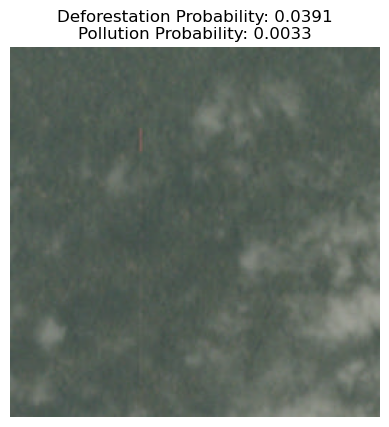

1/1 [==============================] - 0s 203ms/step


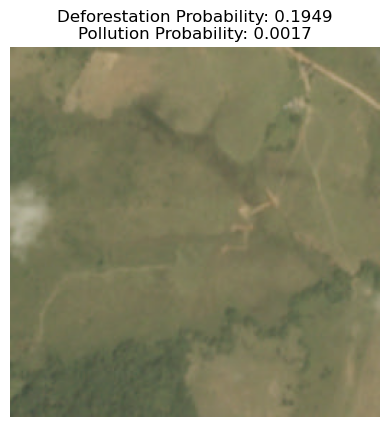

1/1 [==============================] - 0s 239ms/step


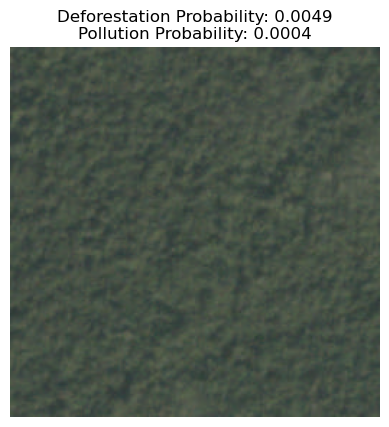

1/1 [==============================] - 0s 310ms/step


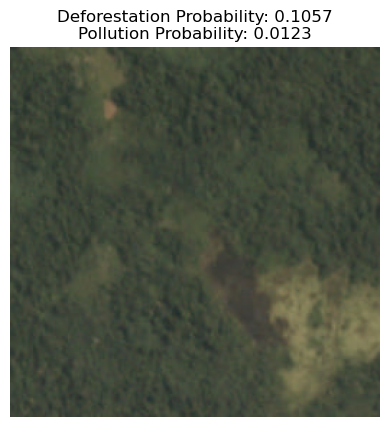

1/1 [==============================] - 0s 174ms/step


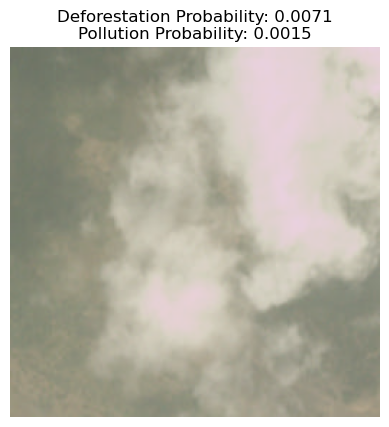

In [25]:
# %%

# Evaluate model's performance on selected test images
for img_name in test_images_MobileNetV2:
    img_path = os.path.join(test_data_dir, img_name)
    preds_MobileNetV2 = predict_deforestation_pollution_MobileNetV2(MobileNetV2model, img_path)

    deforestation_prob_MobileNetV2 =  preds_MobileNetV2[0][0]
    pollution_prob_MobileNetV2 =  preds_MobileNetV2[0][1]

    display_image_with_predictions_MobileNetV2(img_path, deforestation_prob_MobileNetV2, pollution_prob_MobileNetV2)


# 3. Build our own model

## 3.1 DeepForestNet

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [53]:
class DeepForestNet:
    def __init__(self, input_shape=(224, 224, 3), num_classes=2):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()
        self.history = None

    def build_model(self):
        input_tensor = Input(shape=self.input_shape)
        
        # Initial Convolution Block
        x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        # Residual Blocks
        x = self.residual_block(x, filters=[64, 64, 256], strides=1)
        x = self.residual_block(x, filters=[128, 128, 512], strides=2)
        x = self.residual_block(x, filters=[256, 256, 1024], strides=2)
        x = self.residual_block(x, filters=[512, 512, 2048], strides=2)

        # Global Average Pooling
        x = GlobalAveragePooling2D()(x)

        # Fully Connected Layer
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)  # Adding dropout for regularization
        x = Dense(256, activation='relu')(x)
        output_tensor = Dense(self.num_classes, activation='sigmoid')(x)

        model = Model(inputs=input_tensor, outputs=output_tensor)

        return model

    def residual_block(self, x, filters, strides=1):
        shortcut = x

        # First convolutional layer
        x = Conv2D(filters[0], (1, 1), strides=strides)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        # Second convolutional layer
        x = Conv2D(filters[1], (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        # Third convolutional layer
        x = Conv2D(filters[2], (1, 1))(x)
        x = BatchNormalization()(x)

        # Adjust the shortcut's shape if necessary
        if strides != 1 or shortcut.shape[-1] != filters[2]:
            shortcut = Conv2D(filters[2], (1, 1), strides=strides)(shortcut)
            shortcut = BatchNormalization()(shortcut)

        # Add the shortcut to the main path
        x = Add()([x, shortcut])
        x = ReLU()(x)

        return x

    def compile_model(self):
        optimizer = Adam(learning_rate=0.001)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC(name='auc')])

    def train(self, train_generator, val_generator, epochs=3):
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator
        )

    def evaluate(self, test_generator):
        return self.model.evaluate(test_generator)

    def predict(self, img_path):
        img = image.load_img(img_path, target_size=self.input_shape[:2])
        x = image.img_to_array(img)
        x = x / 255.0
        x = x.reshape((1,) + x.shape)

        return self.model.predict(x)

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to create generator for the dataset
def create_dataset_generator(df, data_dir, batch_size=32, target_size=(224, 224), class_mode='raw'):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        df, directory=data_dir, x_col='image_name', y_col=['deforestation', 'pollution'],
        target_size=target_size, batch_size=batch_size, class_mode=class_mode)
    return generator

In [55]:
# Load labels
labels_df = pd.read_csv(r'C:/Users/natti/OneDrive/Desktop/DS/ML/Project Deep Forest/Dataset/train_v2.csv/train_v2.csv')

In [56]:
# Create binary labels for 'habitation' and 'slash_burn'
labels_df['deforestation'] = labels_df['tags'].apply(lambda x: 1 if 'habitation' in x else 0)
labels_df['pollution'] = labels_df['tags'].apply(lambda x: 1 if 'slash_burn' in x else 0)

In [57]:
# Split dataset into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# Add file extensions to image filenames
train_df['image_name'] = train_df['image_name'].apply(lambda x: os.path.join(data_dir, f"{x}.jpg"))
val_df['image_name'] = val_df['image_name'].apply(lambda x: os.path.join(data_dir, f"{x}.jpg"))

In [58]:
# Set the path to dataset directory
data_dir = r'C:/Users/natti/OneDrive/Desktop/DS/ML/Project Deep Forest/Dataset/train-jpg/train-jpg'

In [59]:
# Create dataset generators for training and validation sets
train_generator = create_dataset_generator(train_df, data_dir)
val_generator = create_dataset_generator(val_df, data_dir)

Found 32383 validated image filenames.
Found 8096 validated image filenames.


In [60]:
# Instantiate the DeepForestNet model
DeepForestNet_scratch = DeepForestNet(input_shape=(224, 224, 3), num_classes=2)

In [61]:
# Compile the model
DeepForestNet_scratch.compile_model()
DeepForestNet_scratch.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 112, 112, 64)         9472      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_17 (Ba  (None, 112, 112, 64)         256       ['conv2d_17[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_13 (ReLU)             (None, 112, 112, 64)         0         ['batch_normalization_17

In [46]:
# Train the model
DeepForestNet_scratch.train(train_generator, val_generator, epochs=3)

Epoch 1/3
1012/1012 [==============================] - 3555s 4s/step - loss: 0.1492 - auc: 0.8689 - val_loss: 0.1308 - val_auc: 0.9157
Epoch 2/3
1012/1012 [==============================] - 4799s 5s/step - loss: 0.1176 - auc: 0.9118 - val_loss: 0.2179 - val_auc: 0.7812
Epoch 3/3
1012/1012 [==============================] - 27088s 27s/step - loss: 0.1095 - auc: 0.9193 - val_loss: 0.1393 - val_auc: 0.8976


In [50]:
# Predict on a random test image
img_path = val_df['image_name'].iloc[0]
predictions = DeepForestNet_scratch.predict(img_path)
print('Predictions:', predictions)

1/1 [==============================] - 1s 602ms/step
Predictions: [[0.01217801 0.00644756]]


In [51]:
# Function to display predictions with DeepForestNet Model
def display_image_with_predictions_DeepForestNet(img_path, deforestation_prob, pollution_prob):
    img = image.load_img(img_path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Deforestation Probability: {deforestation_prob:.4f}\nPollution Probability: {pollution_prob:.4f}")
    plt.axis("off")
    plt.show()

In [52]:
# Set path to the test dataset directory
test_data_dir = r'C:\Users\natti\OneDrive\Desktop\DS\ML\Project Deep Forest\Dataset\test-jpg\test-jpg'

In [53]:
# Choose a few random images from test dataset
test_images_DeepForestNet = random.sample(os.listdir(test_data_dir), 5)

1/1 [==============================] - 0s 282ms/step


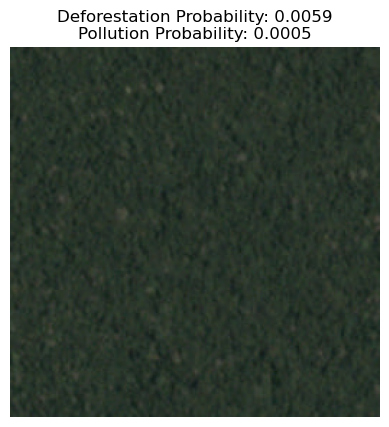

1/1 [==============================] - 0s 151ms/step


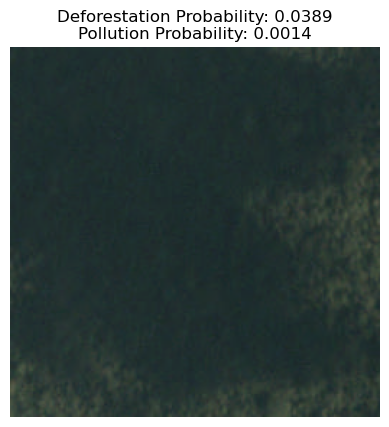

1/1 [==============================] - 0s 164ms/step


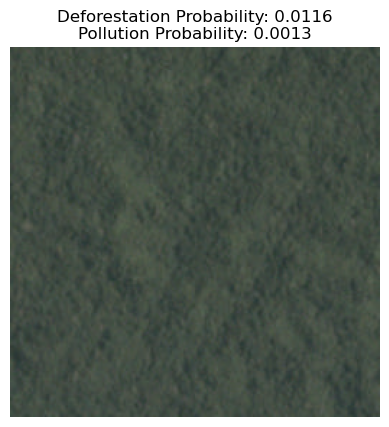

1/1 [==============================] - 0s 176ms/step


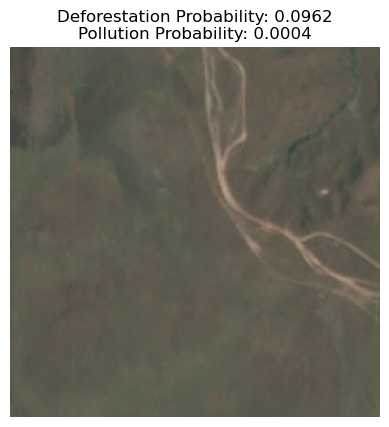

1/1 [==============================] - 0s 165ms/step


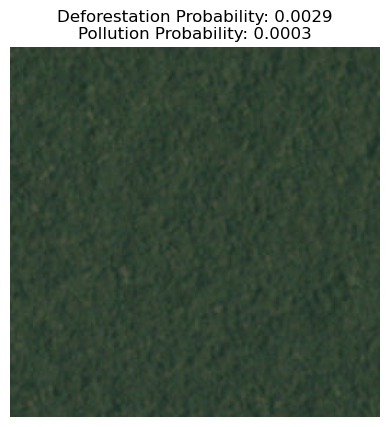

In [54]:
# Evaluate DeepForestNet's performance on selected test images
for img_name in test_images_DeepForestNet:
    img_path = os.path.join(test_data_dir, img_name)
    preds_DeepForestNet = DeepForestNet_scratch.predict(img_path)

    deforestation_prob_DeepForestNet = preds_DeepForestNet[0][0]
    pollution_prob_DeepForestNet = preds_DeepForestNet[0][1]

    display_image_with_predictions_DeepForestNet(img_path, deforestation_prob_DeepForestNet, pollution_prob_DeepForestNet)

# 4. Model Comparison

In [62]:
# Exemple de métriques pour chaque modèle à chaque époque
metrics_Resnet = {
    'Epoch 1': {'val_auc': 0.8824, 'val_loss': 0.1599},
    'Epoch 2': {'val_auc': 0.8821, 'val_loss': 0.1533},
    'Epoch 3': {'val_auc': 0.8789, 'val_loss': 0.1642}
}

metrics_VGG = {
    'Epoch 1': {'val_auc': 0.9309, 'val_loss': 0.1020},
    'Epoch 2': {'val_auc': 0.9407, 'val_loss': 0.1035},
    'Epoch 3': {'val_auc': 0.9335, 'val_loss': 0.1009}
}

metrics_MobileNet = {
    'Epoch 1': {'val_auc': 0.9377, 'val_loss': 0.1140},
    'Epoch 2': {'val_auc': 0.9545, 'val_loss': 0.0910},
    'Epoch 3': {'val_auc': 0.9531, 'val_loss': 0.0915}
}
metrics_DeepForestNet = {
    'Epoch 1': {'val_auc': 0.6989, 'val_loss': 0.3775},
    'Epoch 2': {'val_auc': 0.9213, 'val_loss': 0.1170},
    'Epoch 3': {'val_auc': 0.7851, 'val_loss': 0.2241}
}

In [63]:
# Création de DataFrames pour chaque modèle avec les métriques pour chaque époque
df_resnet = pd.DataFrame(metrics_Resnet).T
df_vgg = pd.DataFrame(metrics_VGG).T
df_mobilenet = pd.DataFrame(metrics_MobileNet).T
df_deepforestnet = pd.DataFrame(metrics_DeepForestNet).T

In [64]:
# Afficher les DataFrames
print("Métriques pour ResNet50 :\n", df_resnet)
print("Métriques pour ResNet50 :\n", df_vgg)
print("\nMétriques pour MobileNetV2 :\n", df_mobilenet)
print("\nMétriques pour DeepForestNet :\n", df_deepforestnet)

Métriques pour ResNet50 :
          val_auc  val_loss
Epoch 1   0.8824    0.1599
Epoch 2   0.8821    0.1533
Epoch 3   0.8789    0.1642
Métriques pour ResNet50 :
          val_auc  val_loss
Epoch 1   0.9309    0.1020
Epoch 2   0.9407    0.1035
Epoch 3   0.9335    0.1009

Métriques pour MobileNetV2 :
          val_auc  val_loss
Epoch 1   0.9377    0.1140
Epoch 2   0.9545    0.0910
Epoch 3   0.9531    0.0915

Métriques pour DeepForestNet :
          val_auc  val_loss
Epoch 1   0.6989    0.3775
Epoch 2   0.9213    0.1170
Epoch 3   0.7851    0.2241


In [65]:
# Stocker les DataFrames dans une liste
list_of_dfs = [df_resnet, df_vgg, df_mobilenet, df_deepforestnet]

# Concaténer les DataFrames en un seul DataFrame
model_comparison_table = pd.concat(list_of_dfs, keys=['ResNet50', 'VGG','MobileNetV2', 'DeepForestNet'])

print(model_comparison_table)

                       val_auc  val_loss
ResNet50      Epoch 1   0.8824    0.1599
              Epoch 2   0.8821    0.1533
              Epoch 3   0.8789    0.1642
VGG           Epoch 1   0.9309    0.1020
              Epoch 2   0.9407    0.1035
              Epoch 3   0.9335    0.1009
MobileNetV2   Epoch 1   0.9377    0.1140
              Epoch 2   0.9545    0.0910
              Epoch 3   0.9531    0.0915
DeepForestNet Epoch 1   0.6989    0.3775
              Epoch 2   0.9213    0.1170
              Epoch 3   0.7851    0.2241


In [68]:
import seaborn as sns

# Reshape DataFrames for plotting
df_resnet['model'] = 'ResNet'
df_vgg['model'] = 'VGG'
df_mobilenet['model'] = 'MobileNet'
df_deepforestnet['model'] = 'DeepForestNet'

df_all = pd.concat([df_resnet, df_vgg, df_mobilenet, df_deepforestnet])

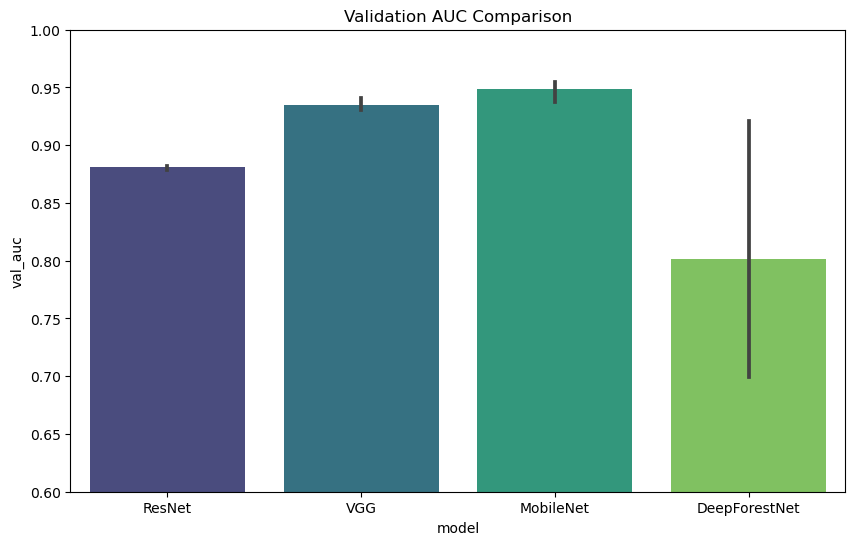

In [72]:
# Plot val_auc
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='val_auc', data=df_all, palette='viridis')
plt.title('Validation AUC Comparison')
plt.ylim(0.6, 1.0)  # Set ylim based on your data range
plt.show()

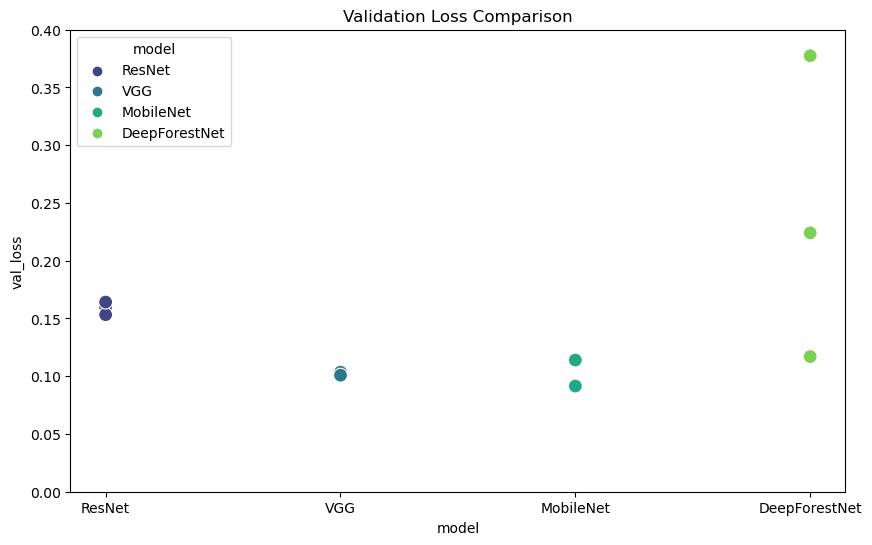

In [75]:
import seaborn as sns

# Scatter plot for val_loss
plt.figure(figsize=(10, 6))
sns.scatterplot(x='model', y='val_loss', data=df_all, hue='model', palette='viridis', s=100)
plt.title('Validation Loss Comparison')
plt.ylim(0, 0.4)  # Set ylim based on your data range
plt.show()
